In [1]:
import pm4py
import os
import pandas as pd

# Q1. Inductive Miner

> In this question you should discover a model for the given event log with a special focus on the Inductive Miner implemented in PM4Py.

## Data loading and exploration

In [2]:
data_path = "log.csv"
figures_dir = "./figures/"

assert os.path.exists(data_path)

# load csv and rename patieent and activity column
df_log = pd.read_csv(data_path)

# convert timestamp columns to datetime friendly format
df_log['Timestamp'] = pd.to_datetime(df_log['Timestamp'])
df_log['start_timestamp'] = pd.to_datetime(df_log['start_timestamp'])

# rename certain columns to ensure recognition by pm4py
df_log = df_log.rename(columns={"Age": "case:Age", "Insurance": "case:Insurance", "PatientName": "case:PatientName"})

df_log.head()

,Patient,Activity,Resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533.0
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895.0
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309.0
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0.0
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692.0


In [3]:
#from pandas_profiling import ProfileReport

#log_profile = ProfileReport(df_log, title="Raw Log Profile")

#log_profile.to_notebook_iframe()

We first verify if the `Patient` has repeated traces, i.e., if it is used again in case the patient returns to the institution. We can test this through the `PatientName` column.

In [4]:
# count unique patient identification number for each patient name
patients_n_ids = df_log.groupby('case:PatientName')['Patient'].nunique()

(patients_n_ids > 1).any()

False

So no patient has more than one ID, which means we can use the `Patient` column as an identifier of the traces.

Let's take a look at some traces:

In [5]:
import numpy as np

# group activities into traces
traces = df_log.groupby('Patient')['Activity'].apply(np.array)

for trace in traces.sample(5).values:
    print(' -> '.join(trace))
    print()

Register -> Initial Exam -> Initial Exam Decision -> Inform about Isolation -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Test III -> Test III Decision -> Discharge Test

Register -> Initial Exam -> Initial Exam Decision -> Inform about Isolation -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Test III -> Test III Decision -> Control Call -> Inform Authority Fill Form -> Control Call -> Control Call -> Control Call -> Control Call -> Referral -> Register Facility -> Decide Treatment -> Treatment B -> Treatment B -> Treatment B -> Check Treatment B -> Treatment B -> Treatment B -> Check Treatment B -> Treatment B -> Discharge

Register -> Initial Exam -> Initial Exam Decision -> Inform about Isolation -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Control Call -> Test III -> Test III Decision -> Discha

Now we transform the dataset into an event log, proper for analysis.

In [6]:
from pm4py.objects.conversion.log import factory as log_converter
from pm4py.util import constants

# map dataset columns to PM4Py keys
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Patient',
            constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
            constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
            constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Timestamp',
            constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'start_timestamp'}

event_log = log_converter.apply(df_log, parameters=param_keys)

event_log

[{'attributes': {'PatientName': 'Hermann the 1.', 'Age': 51, 'Insurance': 'STAT', 'concept:name': 1}, 'events': [{'Patient': 1, 'Activity': 'Register', 'Resource': 'Alexander', 'start_timestamp': Timestamp('2020-06-01 06:00:00'), 'Timestamp': Timestamp('2020-06-01 06:08:53'), '@@duration': 533.0}, '..', {'Patient': 1, 'Activity': 'Discharge', 'Resource': 'Brigitte', 'start_timestamp': Timestamp('2020-06-06 10:58:34'), 'Timestamp': Timestamp('2020-06-06 11:04:55'), '@@duration': 381.0}]}, '....', {'attributes': {'PatientName': 'Ulrich the 1500.', 'Age': 51, 'Insurance': 'PRIV', 'concept:name': 1500}, 'events': [{'Patient': 1500, 'Activity': 'Register', 'Resource': 'Alexander', 'start_timestamp': Timestamp('2020-07-12 11:23:10'), 'Timestamp': Timestamp('2020-07-12 11:33:39'), '@@duration': 629.0}, '..', {'Patient': 1500, 'Activity': 'Discharge Test', 'Resource': 'Alexander', 'start_timestamp': Timestamp('2020-07-14 14:21:11'), 'Timestamp': Timestamp('2020-07-14 14:28:18'), '@@duration': 

## a)

> Apply the Inductive Miner implemented in PM4Py to the given event log and describe the process. Furthermore, give and reason about the fitness and precision results, respectively. On a high level, describe the potential problems of the model and reason how they were caused by the algorithm and the log.

We generate both the petri net and the process tree, the two possible outcomes of the implementation of the inductive miner.

In [7]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.visualization.petrinet import factory as pn_visualizer

net, initial_marking, final_marking = inductive_miner.apply(event_log, parameters=param_keys)

net_graph = pn_visualizer.apply(net, initial_marking=initial_marking, final_marking=final_marking,
                                log=event_log, parameters=param_keys)

# fix places size in the graph
import numpy as np
body = np.array(net_graph.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
net_graph.body = body

net_graph.render(os.path.join(figures_dir, 'q1_a_petrinet'), format='pdf', view=True)

'./figures/q1_a_petrinet.pdf'

In [8]:
from pm4py.visualization.process_tree import factory as pt_visualizer

tree = inductive_miner.apply_tree(event_log, parameters=param_keys)

tree_graph = pt_visualizer.apply(tree)

# fix operations size in the graph
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_a_tree'),
                 format='pdf',
                 view=True)

'./figures/q1_a_tree.pdf'

## b)

> From the process owner we know that patients are called in order to control the quarantine and that there are two potential quarantine phases, i.e., before and after a positive test. Implement a function that resolves the duplicate activity Control Call by context sensitive renaming. Discuss the impact on the discovered model.

Let's assume that the `Test III` is what distinguishes the two `Control Call` possibilities. We'll rename the one after the positive test as `Control Call (+)`.

In [9]:
new_cc_name = 'Control Call (+)'
split_on_activity = 'Test III'

# get `Test III` moment
df_log_test = df_log[df_log['Activity'] == split_on_activity]
split_timestamp = df_log_test.groupby('Patient')['Timestamp'].first()

# map timestamp to whole patient trace
df_renaming = df_log.copy()
df_renaming[split_on_activity + ' Timestamp'] = df_log['Patient'].map(split_timestamp)

# renames `Control Call` activities that happen after `Test III`
new_cc = df_renaming['Activity'].str.replace('Control Call', new_cc_name)
df_renaming['Activity'] = new_cc.where(
    df_renaming['Timestamp'] > df_renaming[split_on_activity + ' Timestamp'],
    df_renaming['Activity']
)
df_renaming['Activity'].value_counts()

Control Call                        5082
Control Call (+)                    4872
Check Treatment A1                  2921
Treatment A1                        2897
Treatment B                         2238
Check Treatment B                   1678
Register                            1438
Initial Exam                        1436
Initial Exam Decision               1419
Check Treatment A2                  1134
Treatment A2                        1133
Test III                             779
Inform about Isolation               758
Test III Decision                    745
Discharge Init Exam                  687
Treatment A3                         595
Check Treatment A3                   584
Inform Authority Send Form           533
Discharge                            532
Inform Authority Fill Form           529
Referral                             529
Decide Treatment                     527
Register Facility                    523
Discharge Test                       216
Prescripe Specia

Check if it worked.

In [10]:
df_renaming['Activity'].value_counts().drop(['Control Call', new_cc_name]) - \
    df_log['Activity'].value_counts().drop('Control Call')

Check Treatment A1                  0
Check Treatment A2                  0
Check Treatment A3                  0
Check Treatment B                   0
Decide Treatment                    0
Discharge                           0
Discharge Init Exam                 0
Discharge Test                      0
Emergency Send 2 Facility (Wait)    0
Inform Authority Fill Form          0
Inform Authority Send Form          0
Inform about Isolation              0
Initial Exam                        0
Initial Exam Decision               0
Prescripe Special Medication        0
Referral                            0
Register                            0
Register Facility                   0
Test III                            0
Test III Decision                   0
Treatment A1                        0
Treatment A2                        0
Treatment A3                        0
Treatment B                         0
Name: Activity, dtype: int64

In [11]:
renamed_traces = df_renaming.groupby('Patient')['Activity'].apply(np.array)

renamed_traces.sample(10).values

array([array(['Register', 'Initial Exam', 'Initial Exam Decision',
       'Discharge Init Exam'], dtype=object),
       array(['Register', 'Initial Exam', 'Initial Exam Decision',
       'Inform about Isolation', 'Control Call', 'Control Call',
       'Control Call', 'Control Call', 'Control Call', 'Control Call',
       'Test III', 'Test III Decision', 'Discharge Test'], dtype=object),
       array(['Register', 'Initial Exam', 'Initial Exam Decision',
       'Inform about Isolation', 'Control Call', 'Control Call',
       'Control Call', 'Control Call', 'Test III', 'Test III Decision',
       'Inform Authority Fill Form', 'Inform Authority Send Form',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Referral', 'Register Facility', 'Decide Treatment', 'Treatment B',
       'Treatment B', 'Treatment B', 'Treatment B', 'Treatment 

No problems detected.

Generate the tree.

In [12]:
# generate a new event log based on the modified dataset
renamed_event_log = log_converter.apply(df_renaming, parameters=param_keys)

#save the renamed event log
from pm4py.objects.log.exporter.xes import factory as xes_exporter
log_path = "processed_log.xes"
xes_exporter.apply(renamed_event_log, log_path)

tree = inductive_miner.apply_tree(renamed_event_log, parameters=param_keys)

tree_graph = pt_visualizer.apply(tree)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_b_tree'),
                 format='pdf',
                 view=True)

'./figures/q1_b_tree.pdf'

## c)

> The log contains a considerable amount of noise induced by errors during the event logging. Apply the IM to a DFG filtered for noise. Describe your results and explain why the IM mines a different model. Which type of noise is prominent in the log?

First we generate the DFG with the log after context-sensitive renaming.

In [13]:
from pm4py.algo.discovery.dfg import factory as dfg_discovery
from pm4py.visualization.dfg import factory as dfg_visualization

dfg = dfg_discovery.apply(renamed_event_log, parameters=param_keys)

dfg_viz = dfg_visualization.apply(dfg, log=renamed_event_log, parameters=param_keys)

dfg_viz.render(os.path.join(figures_dir, 'q1_c_dfg_renaming'),
               format='pdf',
               view=True)

'./figures/q1_c_dfg_renaming.pdf'

Then we filter the graph.

In [14]:
from pm4py.objects.dfg.filtering import dfg_filtering

filt_dfg = dfg_filtering.apply(dfg, parameters=param_keys)

filt_dfg_viz = dfg_visualization.apply(filt_dfg, log=renamed_event_log, parameters=param_keys)

filt_dfg_viz.render(os.path.join(figures_dir, 'q1_c_dfg_filtered'),
                    format='pdf',
                    view=True)

'./figures/q1_c_dfg_filtered.pdf'

We can already notice the improvement through the DFG, which is much more readable. There are way less edges and the flow seems much more linear. Even though, the structure about the treatments A1, A2 and A3 is still unsettled.

Finally, we apply the IM algorithm again.

In [15]:
filt_tree = inductive_miner.apply_tree_dfg(filt_dfg, parameters=param_keys)

tree_graph = pt_visualizer.apply(filt_tree)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_c_filt_tree'),
                  format='pdf',
                  view=True)

'./figures/q1_c_filt_tree.pdf'

The new model generated is much closer to the expected from the superficial analysis of the traces. The noise removed comes mostly from skipped activities, as we can notice that the edges in the DFG reduced and, therefore the amount of silent transitions as well. Still, there are plenty of them, related to the `Treatment A*` activities.

Let's check the traces in which these activities are present.

In [16]:
treatment_A_traces = renamed_traces[renamed_traces.apply(lambda t: any('Treatment A' in a for a in t))]

treatment_A_traces.shape[0]

123

In [17]:
treatment_A_traces.sample(10).values

array([array(['Register', 'Initial Exam', 'Initial Exam Decision',
       'Inform about Isolation', 'Control Call', 'Control Call',
       'Control Call', 'Control Call', 'Control Call', 'Control Call',
       'Control Call', 'Control Call', 'Test III', 'Test III Decision',
       'Prescripe Special Medication', 'Control Call (+)',
       'Inform Authority Fill Form', 'Inform Authority Send Form',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Referral', 'Register Facility', 'Treatment A2',
       'Check Treatment A2', 'Treatment A1', 'Check Treatment A1',
       'Treatment A3', 'Check Treatment A3', 'Treatment A1',
       'Check Treatment A1', 'Check Treatment A1', 'Treatment A2',
       'Check Treatment A2', 'Treatment A1', 'Check Treatment A1',
       'Treatment A1', 'Check Treatment A1', 'Check Treatment A1',
       'Treatment A2', 'Check Treatment A2', 'Treatment A3',
       'Check Treatment A3', 'Treatment A1', 'Check Treatment A1',
       'Treatment A

We can notice how the rarity of traces with `Treatment A*` activities impacted in them being filtered, as the transitions from `Decide Treatment` to the `Treatment A*` were filtered out. But as the `Treatment A*` happen many times in a single trace, the structure was roughly kept.

## d)

> Investigate the DFG of the log after applying the preceding steps. Which activities might be filtered out in order to obtain an improved model that explains most of the process more precisely? Why might this yield better results when applying the IM? Implement a filter and apply the IM to the filtered log.

Perhaps the resulting model can be improved by tuning the noise threshold or by removing the `* Treatment A*` activities completely.

#### Total `* Treatment A*` removal

As the traces in which the A* treatments were applied account for only 123 traces (8,2%), we can say that removing them totally we will still represent the majority of the process.

In [18]:
df_no_A = df_renaming[~df_renaming['Patient'].isin(treatment_A_traces.index)]

df_no_A

,Patient,Activity,Resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration,Test III Timestamp
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533.0,2020-06-01 07:03:47
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895.0,2020-06-01 07:03:47
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309.0,2020-06-01 07:03:47
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0.0,2020-06-01 07:03:47
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692.0,2020-06-01 07:03:47
...,...,...,...,...,...,...,...,...,...,...
33859,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 07:35:39,2020-07-14 07:40:58,319.0,2020-07-14 14:13:27
33860,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 11:05:01,2020-07-14 11:09:47,286.0,2020-07-14 14:13:27
33861,1500,Test III,Amalia,Ulrich the 1500.,51,PRIV,2020-07-14 13:41:46,2020-07-14 14:13:27,1901.0,2020-07-14 14:13:27
33862,1500,Test III Decision,"Amelie,Amalia",Ulrich the 1500.,51,PRIV,2020-07-14 14:13:27,2020-07-14 14:19:18,351.0,2020-07-14 14:13:27


In [19]:
log_no_A = log_converter.apply(df_no_A, parameters=param_keys)

dfg_no_A = dfg_discovery.apply(log_no_A, parameters=param_keys)

dfg_no_A = dfg_filtering.apply(dfg_no_A, parameters=param_keys)

dfg_viz = dfg_visualization.apply(dfg_no_A, log=log_no_A, parameters=param_keys)

dfg_viz.render(os.path.join(figures_dir, 'q1_d_no_A'),
               format='pdf',
               view=True)

'./figures/q1_d_no_A.pdf'

The DFG now looks very concise.

In [20]:
tree_no_A = inductive_miner.apply_tree_dfg(dfg_no_A, parameters=param_keys)

tree_graph = pt_visualizer.apply(tree_no_A)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_d_tree_no_A'),
                  format='pdf',
                  view=True)

'./figures/q1_d_tree_no_A.pdf'

We can see that the PT is also much closer to the majority of the traces, representing well the process. Still, it keeps the silent activities.

#### Partial `* Treatment A*` removal

We can also remove only the activities related to these treatments, keeping the traces. This ensures that we do not loose too much data.

In [21]:
df_silent_A = df_renaming[df_renaming['Activity'].str.find('Treatment A') == -1]
df_silent_A

,Patient,Activity,Resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration,Test III Timestamp
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533.0,2020-06-01 07:03:47
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895.0,2020-06-01 07:03:47
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309.0,2020-06-01 07:03:47
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0.0,2020-06-01 07:03:47
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692.0,2020-06-01 07:03:47
...,...,...,...,...,...,...,...,...,...,...
33859,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 07:35:39,2020-07-14 07:40:58,319.0,2020-07-14 14:13:27
33860,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 11:05:01,2020-07-14 11:09:47,286.0,2020-07-14 14:13:27
33861,1500,Test III,Amalia,Ulrich the 1500.,51,PRIV,2020-07-14 13:41:46,2020-07-14 14:13:27,1901.0,2020-07-14 14:13:27
33862,1500,Test III Decision,"Amelie,Amalia",Ulrich the 1500.,51,PRIV,2020-07-14 14:13:27,2020-07-14 14:19:18,351.0,2020-07-14 14:13:27


In [22]:
log_silent_A = log_converter.apply(df_silent_A, parameters=param_keys)

dfg_silent_A = dfg_discovery.apply(log_silent_A, parameters=param_keys)

dfg_silent_A = dfg_filtering.apply(dfg_silent_A, parameters=param_keys)

dfg_viz = dfg_visualization.apply(dfg_silent_A, log=log_silent_A, parameters=param_keys)

dfg_viz.render(os.path.join(figures_dir, 'q1_d_silent_A'),
               format='pdf',
               view=True)

'./figures/q1_d_silent_A.pdf'

We notice this way the `Prescripe Special Medication` activity is kept.

In [23]:
tree_silent_A = inductive_miner.apply_tree_dfg(dfg_silent_A, parameters=param_keys)

tree_graph = pt_visualizer.apply(tree_silent_A)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_d_tree_silent_A'),
                  format='pdf',
                  view=True)

'./figures/q1_d_tree_silent_A.pdf'

The biggest difference in the Process Tree is that the `Discharge Test` activity was dragged away from the exclusive choice operator with the other 3 activities to a different exclusive choice with `Prescripe Special Medication`.

#### Noise threshold tuning

For the reasons stated in c), the noise threshold will be tuned.

In [24]:
param_keys['noiseThreshold'] = 0.07

filt_dfg = dfg_filtering.apply(dfg, parameters=param_keys)

filt_dfg_viz = dfg_visualization.apply(filt_dfg, log=renamed_event_log, parameters=param_keys)

filt_dfg_viz.render(os.path.join(figures_dir, 'q1_d_dfg_noise_threshold_tuning'),
                    format='pdf',
                    view=True)

'./figures/q1_d_dfg_noise_threshold_tuning.pdf'

We can already notice the improvement in the DFG, which is much more readable. There are way less edges and the flow seems much more linear. Even though, the structure about the treatments A1, A2 and A3 is still unsettled.

In [25]:
filt_tree = inductive_miner.apply_tree_dfg(filt_dfg, parameters=param_keys)

tree_graph = pt_visualizer.apply(filt_tree)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_d_noise_threshold_tuning'),
                  format='pdf',
                  view=True)

'./figures/q1_d_noise_threshold_tuning.pdf'

Even though the final model is not so readable and can still accept some unreasonable mixes between applying one treatment and checking for another, one can say that it is more complete as to the amount of structures that it presents.

In [26]:
from pm4py.objects.conversion.process_tree import factory as pt_converter
from pm4py.objects.petri.exporter import factory as pnml_exporter

# convert the obtained process tree into a petri net
filt_net, filt_initial_marking, filt_final_marking = pt_converter.apply(filt_tree, variant=pt_converter.TO_PETRI_NET)

#save the obtained petri net for further use
pnml_path = "filtered_petri.pnml"
pnml_exporter.apply(filt_net, filt_initial_marking, pnml_path, final_marking=filt_final_marking)

## e)

> Consider the process model for the patients who were prescript the special medication. What do you observe? How is this behavior captured by the complete model in d)?

Let's have a look at the traces that contain this activity.

In [27]:
special_medication_traces = renamed_traces[renamed_traces.apply(lambda t: 'Prescripe Special Medication' in t)]

special_medication_traces.sample(10).values

array([array(['Register', 'Initial Exam', 'Initial Exam Decision',
       'Inform about Isolation', 'Control Call', 'Control Call',
       'Control Call', 'Control Call', 'Control Call', 'Control Call',
       'Test III', 'Test III Decision', 'Prescripe Special Medication',
       'Control Call (+)', 'Control Call (+)',
       'Inform Authority Fill Form', 'Inform Authority Send Form',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Control Call (+)', 'Control Call (+)',
       'Control Call (+)', 'Referral', 'Register Facility',
       'Decide Treatment', 'Treatment A3', 'Check Treatment A3',
       'Treatment A2', 'Check Treatment A2', 'Treatment A1',
       'Check Treatment

In [28]:
special_medication_traces[special_medication_traces.apply(lambda t: 'Treatment B' in t)]

Series([], Name: Activity, dtype: object)

Through further inspection we can assume that the special medication is only prescribed together with the A treatments, therefore it was damaged by the actions taken in d), as previously highlighted.

So we'll generate the model just for the patients that were prescribed special medication to.

In [29]:
df_special = df_renaming[df_renaming['Patient'].isin(special_medication_traces.index)]

df_special

,Patient,Activity,Resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration,Test III Timestamp
405,31,Register,Alexander,Alexander the 31.,60,STAT,2020-06-01 15:24:21,2020-06-01 15:33:24,543.0,2020-06-02 10:58:47
406,31,Initial Exam,Anna,Alexander the 31.,60,STAT,2020-06-01 15:35:24,2020-06-01 15:50:21,897.0,2020-06-02 10:58:47
407,31,Inform about Isolation,Anna,Alexander the 31.,60,STAT,2020-06-01 15:58:38,2020-06-01 15:58:38,0.0,2020-06-02 10:58:47
408,31,Control Call,InspectorInis,Alexander the 31.,60,STAT,2020-06-01 19:00:26,2020-06-01 19:05:29,303.0,2020-06-02 10:58:47
409,31,Control Call,InspectorInis,Alexander the 31.,60,STAT,2020-06-02 06:00:00,2020-06-02 06:05:11,311.0,2020-06-02 10:58:47
...,...,...,...,...,...,...,...,...,...,...
33171,1460,Check Treatment A2,"Caddy,Cornelia",Dietrich the 1460.,59,STAT,2020-07-29 16:55:35,2020-07-29 17:00:29,294.0,2020-07-13 15:10:20
33172,1460,Treatment A1,Carla,Dietrich the 1460.,59,STAT,2020-07-29 22:53:20,2020-07-29 23:13:04,1184.0,2020-07-13 15:10:20
33173,1460,Check Treatment A1,"Carlotta,Carla",Dietrich the 1460.,59,STAT,2020-07-29 23:14:25,2020-07-29 23:19:38,313.0,2020-07-13 15:10:20
33174,1460,Treatment A1,Claudia,Dietrich the 1460.,59,STAT,2020-07-30 07:19:51,2020-07-30 07:39:25,1174.0,2020-07-13 15:10:20


In [30]:
log_special = log_converter.apply(df_special, parameters=param_keys)

dfg_special = dfg_discovery.apply(log_special, parameters=param_keys)

dfg_special = dfg_filtering.apply(dfg_special, parameters=param_keys)

dfg_viz = dfg_visualization.apply(dfg_special, log=log_special, parameters=param_keys)

dfg_viz.render(os.path.join(figures_dir, 'q1_e_special'),
               format='pdf',
               view=True)

'./figures/q1_e_special.pdf'

In [31]:
tree_special = inductive_miner.apply_tree_dfg(dfg_special, parameters=param_keys)

tree_graph = pt_visualizer.apply(tree_special)

# fix operations size
tree_graph.body = list(map(lambda r:r.replace('width=0.6', 'width=1'),
                           tree_graph.body))

tree_graph.render(os.path.join(figures_dir, 'q1_e_tree_special'),
                  format='pdf',
                  view=True)

'./figures/q1_e_tree_special.pdf'

It is very similar, as previously stated. One can say that the previous models failed to capture the non-local influence of the `Prescripe Special Medication` in the choice of the treatment, which it is possible to assume that must be one of the A treatments.

## f)

> Apply additional miners to the log and compare the results. Which model is the best model?

#### Alpha Miner

In [32]:
from pm4py.algo.discovery.alpha import factory as alpha_miner
from pm4py.objects.dfg.filtering.dfg_filtering import DEFAULT_NOISE_THRESH_DF

param_keys['noiseThreshold'] = DEFAULT_NOISE_THRESH_DF
filt_dfg = dfg_filtering.apply(dfg, parameters=param_keys)

net, initial_marking, final_marking = alpha_miner.apply_dfg(filt_dfg, parameters=param_keys)

net_graph = pn_visualizer.apply(net,
                                initial_marking=initial_marking,
                                final_marking=final_marking)

# fix place size
import numpy as np
body = np.array(net_graph.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
net_graph.body = body

net_graph.render(os.path.join(figures_dir, 'q1_f_alpha_miner'),
                 format='pdf',
                 view=True)

'./figures/q1_f_alpha_miner.pdf'

#### Heuristics Miner

In [33]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner

net, initial_marking, final_marking = heuristics_miner.apply_dfg(filt_dfg, parameters=param_keys)

net_graph = pn_visualizer.apply(net,
                                initial_marking=initial_marking,
                                final_marking=final_marking)

# fix place size
import numpy as np
body = np.array(net_graph.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
net_graph.body = body

net_graph.render(os.path.join(figures_dir, 'q1_f_heuristics_miner'),
                 format='pdf',
                 view=True)

'./figures/q1_f_heuristics_miner.pdf'

The Alpha miner fails completely to most of the structures beyond the initial activities. The Heuristics miner presents a good job up until the treatments start, showing precisely the control calls and its relation with the `Inform Authority*` activities. Both fail to understand non-local influence of the `Prescripe Special Medication` and the sequencing of the A treatments and checks. Therefore, one can say the most precise model is still the one generated by the IM, even though the one generated by the HM is more readable.

# Social Network Analysis

> Discover the organizational perspective of the process. For each of the following networks, try to find a clear organizational structure and discuss the structure obtained. If no clear structure is to be found, explain why this is the case.

---

# a)
> Handover-of-Work Social Network

In [34]:
# define the path where the resulting networks will be stored
RESULT_PATH = figures_dir

In [35]:
from pm4py.algo.enhancement.sna import factory as sna_factory
from pm4py.visualization.sna import factory as sna_vis_factory

#discover the network
handover_net = sna_factory.apply(event_log, parameters=param_keys, variant="handover")

#create a visualization of the network
handover_viz = sna_vis_factory.apply(handover_net, variant="pyvis")

#save the visualization of the discovered network
sna_vis_factory.save(handover_viz, RESULT_PATH+"handover_net.html", variant="pyvis")


As the pyvis interactive visualization cannot be embedded, the discovered network is shown below in the form of an image. The real network can be found in the figures folder.

![](./figures/q2_handover.png)

A handover-of-work network connects two resources when an activity performed by one resource directly follows the activity performed by another resource. The more frequent this relationship is in the log, the higher is the weight of an edge. In the graphic above the handover-of-work network that was discovered from the given log can be seen.

We see that the network consists of four strongly connected main components and a single resource that has only one connection. Further we see that the resources in each of the strongly connected components all have a common first letter. The outer three components contain resources with first letters B, C and D. The inner component consists of resources with the first letter A. The nodes in the three outer components are connected only to themselves and the inner A component, but not to the other outer components. Most of the nodes in the A component have connections to all other components and the nodes in the A component have overall the most connections to other nodes. There is a single resource that does not belong to any of the components and has only one incoming edge.

From an orgainzational perspective the observed network might be explained in the following way: The outer components B, C, D all represent certain distinct departments. All of the resources in such a department do similar work and are working together on a certain part of the process. The central A component however consist of resources that are delegating and inspecting work. They pass process instances from one department to another. Since the singular resource has only incoming edges, it must be concerned with the end of the process. It might be a kind of supervisor role that makes a final assertion of a process before it ends. However this node is not involved in most cases, as its connection is rather weak.

---

# b)
> Subcontracting Social Network

In [36]:
#discover the network
subcontracting_net = sna_factory.apply(event_log, parameters=param_keys, variant="subcontracting")

#create a visualization of the network
subcontracting_viz = sna_vis_factory.apply(subcontracting_net, variant="pyvis")

#save the visualization of the discovered network
sna_vis_factory.save(subcontracting_viz, RESULT_PATH+"subcontracting_net.html", variant="pyvis")

As the pyvis interactive visualization cannot be embedded, the discovered network is shown below in the form of an image. The real network can be found in the figure folder.

![](./figures/q2_subcontracting.png)

A subcontracting social network visualizes what resources are involved in the work of another resource.

The obtained network that can be seen above has a kind of forest structure. We again see distinct connected components that show the same A, B, C, D division as in the handover-of-work network discussed above. There is one component for each of these, except for the A component, which now consists of two not connected components. As a common structure we can observe a kind of star pattern for many nodes, meaning that one resource is involved in the work of many other resources. We can see that one of the A components has a very strong relation between two of the resources.

From an organizational perspective we can again see that the work of one department never involves the work of another department. Subcontracting only happens within the A, B, C, D departments. The star structures suggest that there are supervisor roles, resources that often subcontract work to other resources which do not subcontract any work. The strong connection between the _Alexander_ and _Ava_ resources suggests that Alexander is in a leadership position and Ava might be her secretary, as most of the work is subcontracted.

---

# c)
> Working-Together Social Network

In [37]:
#discover the network
working_together_net = sna_factory.apply(event_log, parameters=param_keys, variant="working_together")

#create a visualization of the network
working_together_viz = sna_vis_factory.apply(working_together_net, variant="pyvis")

#save the visualization of the discovered network
sna_vis_factory.save(working_together_viz, RESULT_PATH+"working_together_net.html", variant="pyvis")

As the pyvis interactive visualization cannot be embedded, the discovered network is shown below in the form of an image. The real network can be found in the figures folder.

![](./figures/q2_working_together.png)

The working-together network depicts which resources are often working together on the same case, so in which fraction of cases they were both involved.

We see a similar structure as in the hondover-of-work network, which is expected. We again have four main components, with three outer ones and an inner one, following the recurring A, B, C, D pattern. We see that the connections in this network are even stronger than in the handover of work network. All of the components are almost fully connected. The inner A component is most strongly connected. Again the outer components have no connections to the other outer connections, but are all connected to the inner component. The singular resource is again present and is only connected to resources in the A component.

From an organizational point of view, we see that the resources in the A component are the most important ones. They are involved in almost all cases and are almost always working together. Again it seems that they delegate work to the outer components. The almost full connection of the components suggests that when a department is involved in a case at all, usually the whole department is involved and not only certain resources. From the subcontracting network we have seen that in the outer components, much of the work is subcontracted, which explains the involvement of many different resources of each component we can see in the working-together network.

--- 

# d)
> Joint-Activity Network

In [38]:
#discover the network
jointactivities_net = sna_factory.apply(event_log, parameters=param_keys, variant="jointactivities")

#create a visualization of the network
jointactivities_viz = sna_vis_factory.apply(jointactivities_net, variant="pyvis")

#save the visualization of the discovered network
sna_vis_factory.save(jointactivities_viz, RESULT_PATH+"jointactivities_net.html", variant="pyvis")

As the pyvis interactive visualization cannot be embedded, the discovered network is shown below in the form of an image. The real network can be found in the figures folder.

![](./figures/q2_jointactivities.png)

The jointactivities network depicts how similar the types of activities are that the resources perform. Meaning that two resources have a strong connection if they always perform the same e.g. three activities but never any other.

The structure of the obtained network is very different from all networks we have considered up to this point. It consists of six strongly connected components. It seems that all of the components are fully connected, meaning that all resources in a component perform very similar activities. We see that the destinction between components is no longer based on the first letter of the resource name, as we have seen before. The components are now mixtures of these resources. This is not true for one of the components, which only contains A resources.

For the organizational structure this again suggests the supervisor role for the A resources, there are certain activities that are only performed by these resources. Other activities however seem to occur in all of the B, C, D departments. Combining these findings with the findings from the other networks we cann assume that the process is structured in such a way that the A department is a supervision department that performs certain specialized taks. The other departments B, C, D, however perform similar activities (as the jointactivities network suggest) but they never mix. This suggests that a case is delegate by the A resources to one of the departments and this department then fully handles the case. It is in a way not a delegation of cases based on certain types of cases, but just a balancing of cases over all departments.

In the following we are taking a closer look at the relation between groups and activities.

In [39]:
df_log['Resource']

0            Alexander
1                 Anna
2          Amelie,Anna
3            Alexander
4                 Anna
             ...      
33859    InspectorInis
33860    InspectorInis
33861           Amalia
33862    Amelie,Amalia
33863        Alexander
Name: Resource, Length: 33864, dtype: object

In [40]:
first_person_group = df_log['Resource'].str[0]
second_person_group = df_log['Resource'].str.split(',').apply(lambda a: a[-1]).str[0]

(first_person_group != second_person_group).sum()

0

This means that when two resources share the activity, it is contained in one of the groups of strongly connected resources.

In [41]:
df_log['Component'] = first_person_group

df_log['Component'].value_counts()

I    9954
A    9147
B    5401
D    4755
C    4606
H       1
Name: Component, dtype: int64

In [42]:
for c in df_log['Component'].unique():
    print('==== Component ', c)
    print(df_log[df_log['Component'] == c]['Activity'].value_counts())

==== Component  A
Register                        1438
Initial Exam                    1436
Initial Exam Decision           1419
Test III                         779
Inform about Isolation           758
Test III Decision                745
Discharge Init Exam              687
Inform Authority Send Form       533
Inform Authority Fill Form       529
Referral                         529
Discharge Test                   216
Prescripe Special Medication      78
Name: Activity, dtype: int64
==== Component  B
Check Treatment A1    1053
Treatment A1          1047
Treatment B            738
Check Treatment B      737
Check Treatment A2     411
Treatment A2           408
Treatment A3           215
Check Treatment A3     213
Decide Treatment       194
Register Facility      193
Discharge              192
Name: Activity, dtype: int64
==== Component  D
Check Treatment A1    824
Treatment A1          811
Treatment B           795
Check Treatment B     794
Treatment A2          318
Check Treatment A

We verify that, indeed, the components represent groups of resources that act in different activities. We can estimate that groups B, C and D are responsible for the treatment of confirmed cases; group I is responsible for the control call only; H is the helicopter, only used in emergencies; and group A deals with the remaining activities related to the trial of the patients.

### What are the components of the jointacitivites

Right-most component:

In [43]:
df_log[df_log['Resource'] == 'Daniela']['Activity'].unique()

array(['Treatment A1', 'Treatment B', 'Discharge', 'Treatment A2',
       'Treatment A3'], dtype=object)

Most dense ball:

In [44]:
df_log[df_log['Resource'] == 'Benedikt,Bella']['Activity'].unique()

array(['Check Treatment A1', 'Check Treatment A2', 'Check Treatment A3'],
      dtype=object)

In [45]:
df_log[df_log['Resource'] == 'Babatunde,Bruno']['Activity'].unique()

array(['Check Treatment A2', 'Check Treatment A1', 'Check Treatment A3',
       'Check Treatment B'], dtype=object)

In [46]:
df_log[df_log['Resource'] == 'Celina,Cedrik']['Activity'].unique()

array(['Check Treatment A1', 'Check Treatment A3', 'Check Treatment A2',
       'Check Treatment B'], dtype=object)

Line segment:

In [47]:
df_log[df_log['Resource'] == 'Adrian']['Activity'].unique()

array(['Referral', 'Prescripe Special Medication'], dtype=object)

Octogon:

In [48]:
df_log[df_log['Resource'] == 'Adrian,Amalia']['Activity'].unique()

array(['Initial Exam Decision', 'Test III Decision'], dtype=object)

Square:

In [49]:
df_log[df_log['Resource'] == 'Anna']['Activity'].unique()

array(['Initial Exam', 'Test III', 'Inform about Isolation'], dtype=object)

Left-most component:

In [50]:
df_log[df_log['Resource'] == 'Diana']['Activity'].unique()

array(['Decide Treatment'], dtype=object)

# Performance Analysis

> Which parts of the process have the biggest influence on the total case duration?

## Data loading

Import the log.

In [52]:
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.objects.petri.importer import factory as pnml_importer

#import the renamed event log from Q1
event_log = xes_import_factory.apply("processed_log.xes")

#import the filtered petri net obtained in Q1
pnml_path = "filtered_petri.pnml"
net, initial_marking, final_marking = pnml_importer.apply(pnml_path)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# set default plot size
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.figsize'] = (15, 10)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---

# a)
> Provide and briefly describe results of your performance analysis. Remember to also consider your current results which may give you a good entry point for a deeper analysis.

### Activities duration

We start our exploration of the process performance by evaluating the performance of single activities. At first we visualize the activities duration. The results can be found below.

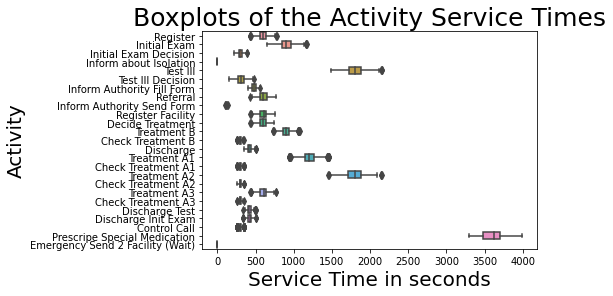

In [54]:
ax = sns.boxplot(data=df_log, y='Activity', x='@@duration', orient='h')
ax.set_title("Boxplots of the Activity Service Times", size=25)
ax.set_ylabel("Activity", size=20)
ax.set_xlabel("Service Time in seconds", size=20)
plt.show()

What we can observe here is that the _Prescripe Special Medication_ activity has by far the largest average duration. Also, _Test III_ has the second largest average duration.

Administrative tasks like registration activities also show a long duration, while examination decisions and treatment checks have the shortest duration.

All of the standard deviations are small considering the overall duration of the activities, this means that there is not much variation in the time that is required for a specific activity in between cases. We also notice that there is no presence of anomalies in the distributions, all of them seem very close to a normal distribution.

In general we see that the activities related to treatments have long durations, we can take a closer look.

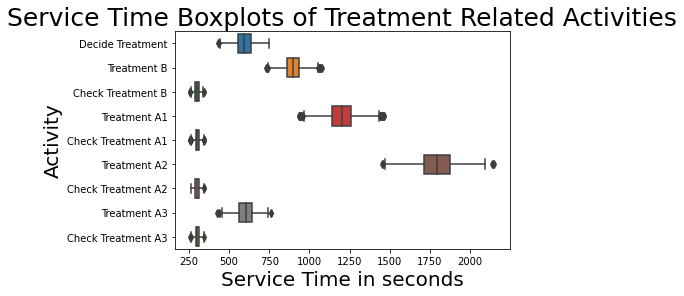

In [55]:
ax = sns.boxplot(data=df_log[df_log['Activity'].str.contains('Treatment')], y='Activity', x='@@duration', orient='h')
ax.set_title("Service Time Boxplots of Treatment Related Activities", size=25)
ax.set_ylabel("Activity", size=20)
ax.set_xlabel("Service Time in seconds", size=20)
plt.show()

We see that _Treatment A2_ has the largest average duration, but knowing that this activities are performed many times in a single process, it is useful to evaluate their summed duration.

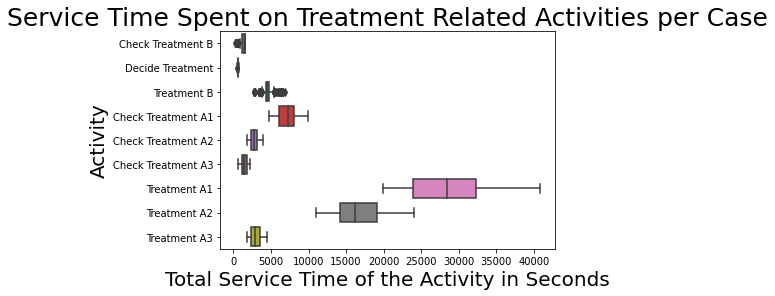

In [56]:
df_activities_duration = (df_log.groupby(['Patient', 'Activity'])['@@duration'].sum()
                                .reset_index().rename({'@@duration': 'total_@@duration'}, axis='columns'))
df_treatment_durations = df_activities_duration[df_activities_duration['Activity'].str.contains('Treatment')]

ax = sns.boxplot(data=df_treatment_durations, y='Activity', x='total_@@duration', orient='h')
ax.set_title("Service Time Spent on Treatment Related Activities per Case", size=25)
ax.set_ylabel("Activity", size=20)
ax.set_xlabel("Total Service Time of the Activity in Seconds", size=20)
plt.show()

So we see that even though _Treatment A2_ has the biggest average duration, it is not the one with the largest total duration (taking on account all the times it was executed) in a process, this being _Treatment A1_.

We can also notice that when we are dealing with the total duration of the activities, the values become bigger by one order of magnitude, which makes us interested in the total duration of the remaining activities.

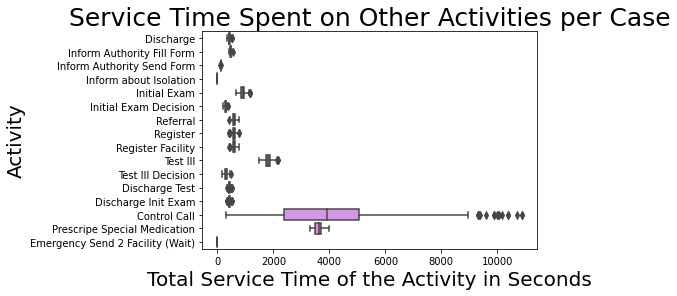

In [57]:
df_ = df_activities_duration[~df_activities_duration['Activity'].str.contains('Treatment')]

ax = sns.boxplot(data=df_, y='Activity', x='total_@@duration', orient='h')
ax.set_title("Service Time Spent on Other Activities per Case", size=25)
ax.set_ylabel("Activity", size=20)
ax.set_xlabel("Total Service Time of the Activity in Seconds", size=20)
plt.show()

This way we can see that the _Control Call_ activity is actually more time demanding than we have estimated by the previous analysis.

In [58]:
total_process_duration = df_log.groupby('Patient')['@@duration'].sum()

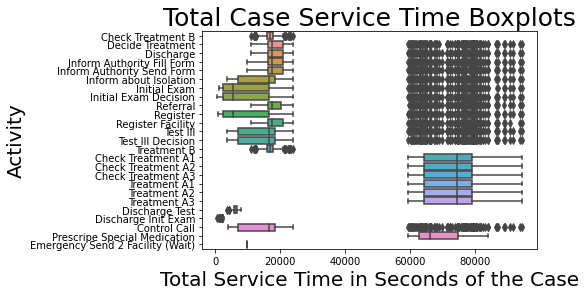

In [59]:
total_process_duration = df_log.groupby('Patient')['@@duration'].sum()
df_activities_duration['process_total_duration'] = df_activities_duration['Patient'].map(total_process_duration)

ax = sns.boxplot(data=df_activities_duration, y='Activity', x='process_total_duration')
ax.set_title("Total Case Service Time Boxplots", size=25)
ax.set_ylabel("Activity", size=20)
ax.set_xlabel("Total Service Time in Seconds of the Case", size=20)
plt.show()

Comparing the activities with the total process duration in which they are present, we see that the Treatments A1, A2 and A3 correlate to much longer processes.

---

# b)
> Discuss insights obtained from you analysis, for example identify bottlenecks, and discuss their impact.

### Process length

We could notice in the previous graph that the processes can be divided in two groups regarding their length, let's take a deeper look into that.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


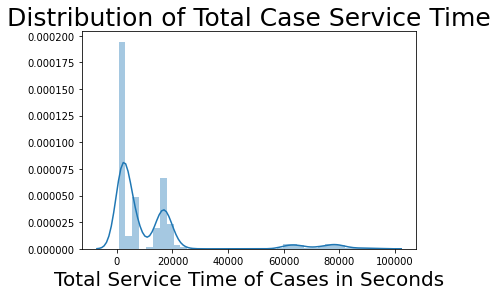

In [60]:
ax = sns.distplot(total_process_duration)
ax.set_title("Distribution of Total Case Service Time", size=25)
ax.set_xlabel("Total Service Time of Cases in Seconds", size=20)
plt.show()

We notice roughly two groups here, separated by the 40000 seconds duration mark.

Let's investigate further if this is also reflected in the lead time of the processes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


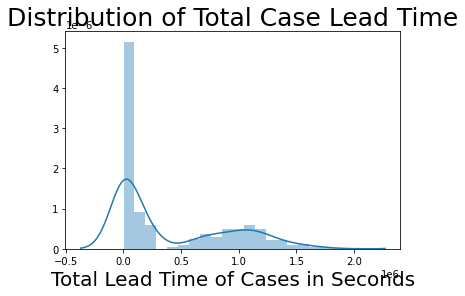

In [61]:
lead_time = df_log.groupby('Patient')['Timestamp'].max() - \
            df_log.groupby('Patient')['start_timestamp'].min()

ax = sns.distplot(lead_time.apply(lambda t: t.total_seconds()), bins=20)
ax.set_title("Distribution of Total Case Lead Time", size=25)
ax.set_xlabel("Total Lead Time of Cases in Seconds", size=20)
plt.show()

Again we see that the lead time has two groupings, split around 370000 seconds.

We can search for the causes of this difference by seeing it as a classification problem being the features the presence of the activities. This way, the most influential features as the main causes for the lead time.

In [62]:
from pm4py.objects.log.util import get_log_representation, get_class_representation

data, feature_names = get_log_representation.get_representation(
    log=event_log,
    str_tr_attr=[],
    str_ev_attr=['Activity'],
    num_tr_attr=[],
    num_ev_attr=[]
)
target, classes = get_class_representation.get_class_representation_by_trace_duration(event_log, target_trace_duration=370000, timestamp_key='Timestamp')

from sklearn.tree import DecisionTreeClassifier

# limit DT depth to get a simpler representation, with the main approaches
clf = DecisionTreeClassifier(min_samples_leaf=5)
# clf = DecisionTreeClassifier(min_samples_leaf=15)
clf = clf.fit(data, target)

from pm4py.visualization.decisiontree import factory as dt_visualizer

dt_vis = dt_visualizer.apply(clf, feature_names, classes)

dt_vis.render(os.path.join(figures_dir, 'q3_decision_tree'),
              #format='pdf',
              view=True)

'./figures/q3_decision_tree.png'

We can see that the major cause for the long lead time of the processes is the happening of `Inform Authority Send Form`, which means that the patient will be forwarded to treatment, therefore taking longer time under observation.

In [64]:
from pm4py.visualization.petrinet import factory as pn_visualizer
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.util import constants

# map dataset columns to PM4Py keys
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Patient',
            constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
            constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
            constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Timestamp',
            constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'start_timestamp'}

#annotate the mined petri net with performance measures
perf_net_vis = pn_visualizer.apply(net, initial_marking, final_marking=final_marking,
                                   variant=pn_visualizer.PERFORMANCE_DECORATION,
                                   log=event_log, parameters=param_keys)

# fix place size
import numpy as np
body = np.array(perf_net_vis.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
perf_net_vis.body = body

perf_net_vis.render(os.path.join(figures_dir, 'q3_perf_petrinet'),
                 #format='pdf',
                 view=True)

'./figures/q3_perf_petrinet.png'

We have annotated the petri net that was obtained in Q1 after preprocessing the log with a performance metric. The metric used is the mean time between two events.

### Components

We can also visualize if the components (as discussed in Q2) have any impact in the performance of the processes.

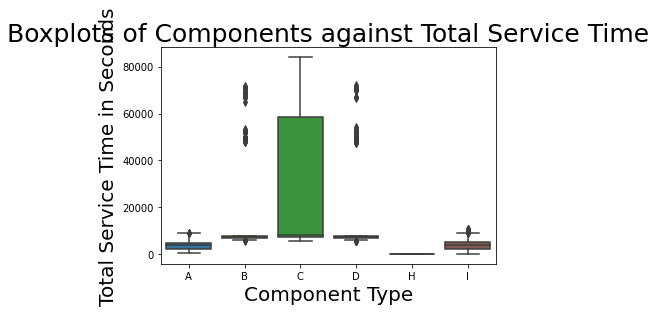

In [65]:
df_log['Component'] = df_log['Resource'].str[0]

df_components = df_log.groupby(['Component', 'Patient'])['@@duration'].sum().reset_index()

ax = sns.boxplot(data=df_components, x='Component', y='@@duration')
ax.set_title("Boxplots of Components against Total Service Time", size=25)
ax.set_xlabel("Component Type", size=20)
ax.set_ylabel("Total Service Time in Seconds", size=20)
plt.show()

We see that the component C is presenting longer processes duration for the activities than their counterparts B and D, which perform similar activities.

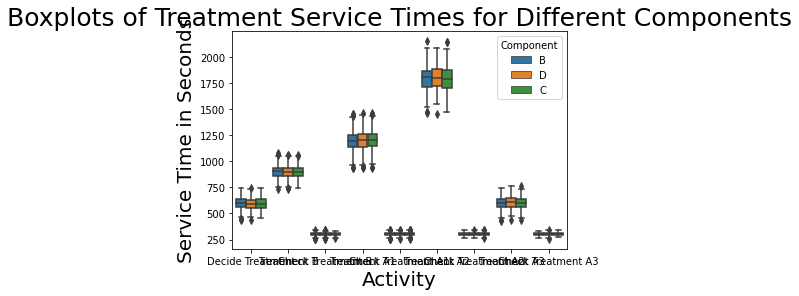

In [66]:
df_treatment = df_log[(df_log['Component'].isin(['B', 'C', 'D'])) & \
                      (df_log['Activity'].str.contains('Treatment'))]

ax = sns.boxplot(data=df_treatment, x='Activity', y='@@duration', hue='Component')
ax.set_title("Boxplots of Treatment Service Times for Different Components", size=25)
ax.set_xlabel("Activity", size=20)
ax.set_ylabel("Service Time in Seconds", size=20)
plt.show()

We see no difference in the performance of the activities comparing the three components that deal with the treatments. Therefore, we can estimate that the difference is in the amount of activities performed in the processes related to component C.

In [67]:
activities_per_component = df_log.groupby('Component')['Activity'].count()
patients_per_component = df_log.groupby('Component')['Patient'].nunique()

activities_per_component / patients_per_component

Component
A     6.098000
B    26.870647
C    30.912752
D    23.308824
H     1.000000
I    13.062992
dtype: float64

We confirm our idea that the component C performs more tasks for each related process, having an average of 31 activities per process (in which it actuates).

### Age

We can also inspect if the age of the patients has any influence on the performance.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


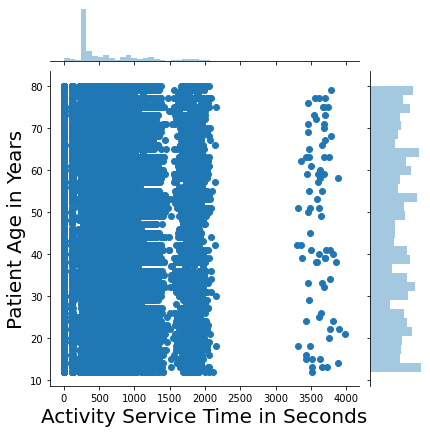

In [69]:
g = sns.jointplot(data=df_log, x='@@duration', y='case:Age')
#g.ax_joint.set_title("Scatterplot of the Activity Service Time Against the age", size=25)
g.ax_joint.set_xlabel("Activity Service Time in Seconds", size=20)
g.ax_joint.set_ylabel("Patient Age in Years", size=20)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


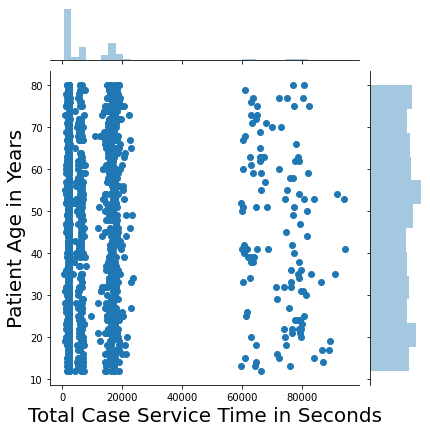

In [70]:
df_ = pd.DataFrame(total_process_duration).rename({'@@duration':'total_duration'}, axis='columns')
df_['case:Age'] = df_log.groupby('Patient')['case:Age'].first()

g = sns.jointplot(data=df_, x='total_duration', y='case:Age')
g.ax_joint.set_xlabel("Total Case Service Time in Seconds", size=20)
g.ax_joint.set_ylabel("Patient Age in Years", size=20)
plt.show()

So we see that neither the duration of the individual activities nor the total duration of the process are related to the age of the patients.

### Insurance

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


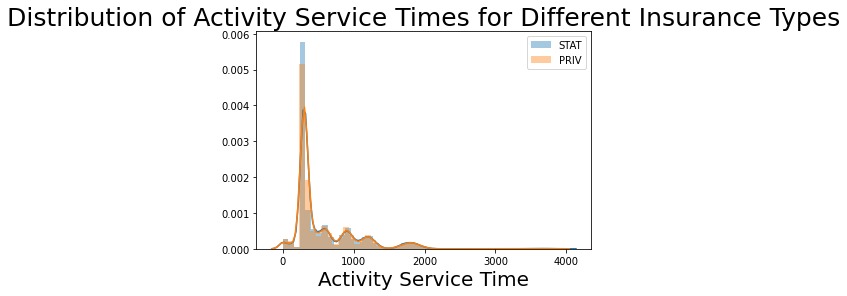

In [71]:
for ins in df_log['case:Insurance'].unique():
    ax = sns.distplot(df_log[df_log['case:Insurance'] == ins]['@@duration'], label=ins)
    ax.set_title("Distribution of Activity Service Times for Different Insurance Types", size=25)
    ax.set_xlabel("Activity Service Time", size=20)

plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


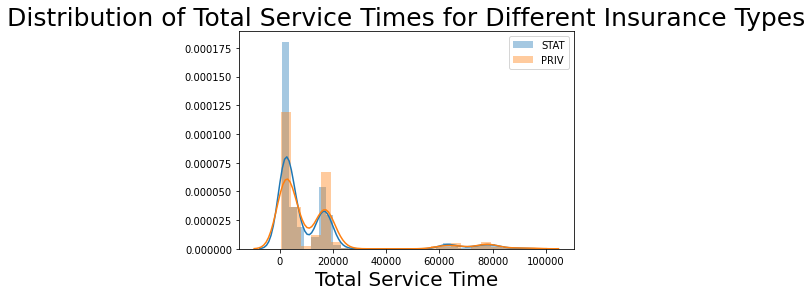

In [73]:
df_['case:Insurance'] = df_log.groupby('Patient')['case:Insurance'].first()

for ins in df_['case:Insurance'].unique():
    ax = sns.distplot(df_[df_['case:Insurance'] == ins]['total_duration'], label=ins)
    ax.set_title("Distribution of Total Service Times for Different Insurance Types", size=25)
    ax.set_xlabel("Total Service Time", size=20)
plt.legend()
plt.show()

Again, no apparent influence.

In [74]:
case_duration = (df_log.groupby('Patient')['Timestamp'].max() - 
                    df_log.groupby('Patient')['start_timestamp'].min())
case_duration = lead_time.apply(lambda x: x.total_seconds())
case_duration.name = 'case_duration'

As we have seen there is a group of cases that take substantially longer than the majority of cases we will now focus on this group for further analysis

In [75]:
new_cc_name = 'Control Call (+)'
split_on_activity = 'Test III'

# get `Test III` moment
df_log_test = df_log[df_log['Activity'] == split_on_activity]
split_timestamp = df_log_test.groupby('Patient')['Timestamp'].first()

# map timestamp to whole patient trace
df_renaming = df_log.copy()
df_renaming[split_on_activity + ' Timestamp'] = df_log['Patient'].map(split_timestamp)

# renames `Control Call` activities that happen after `Test III`
new_cc = df_renaming['Activity'].str.replace('Control Call', new_cc_name)
df_renaming['Activity'] = new_cc.where(
    df_renaming['Timestamp'] > df_renaming[split_on_activity + ' Timestamp'],
    df_renaming['Activity']
)

In [76]:

long_cases = df_renaming.join(case_duration ,on='Patient')
long_cases = long_cases[long_cases['case_duration']>300000]


We can now have a look at the dfg visualisations of the long cases both from a performance and a frequency perspective:

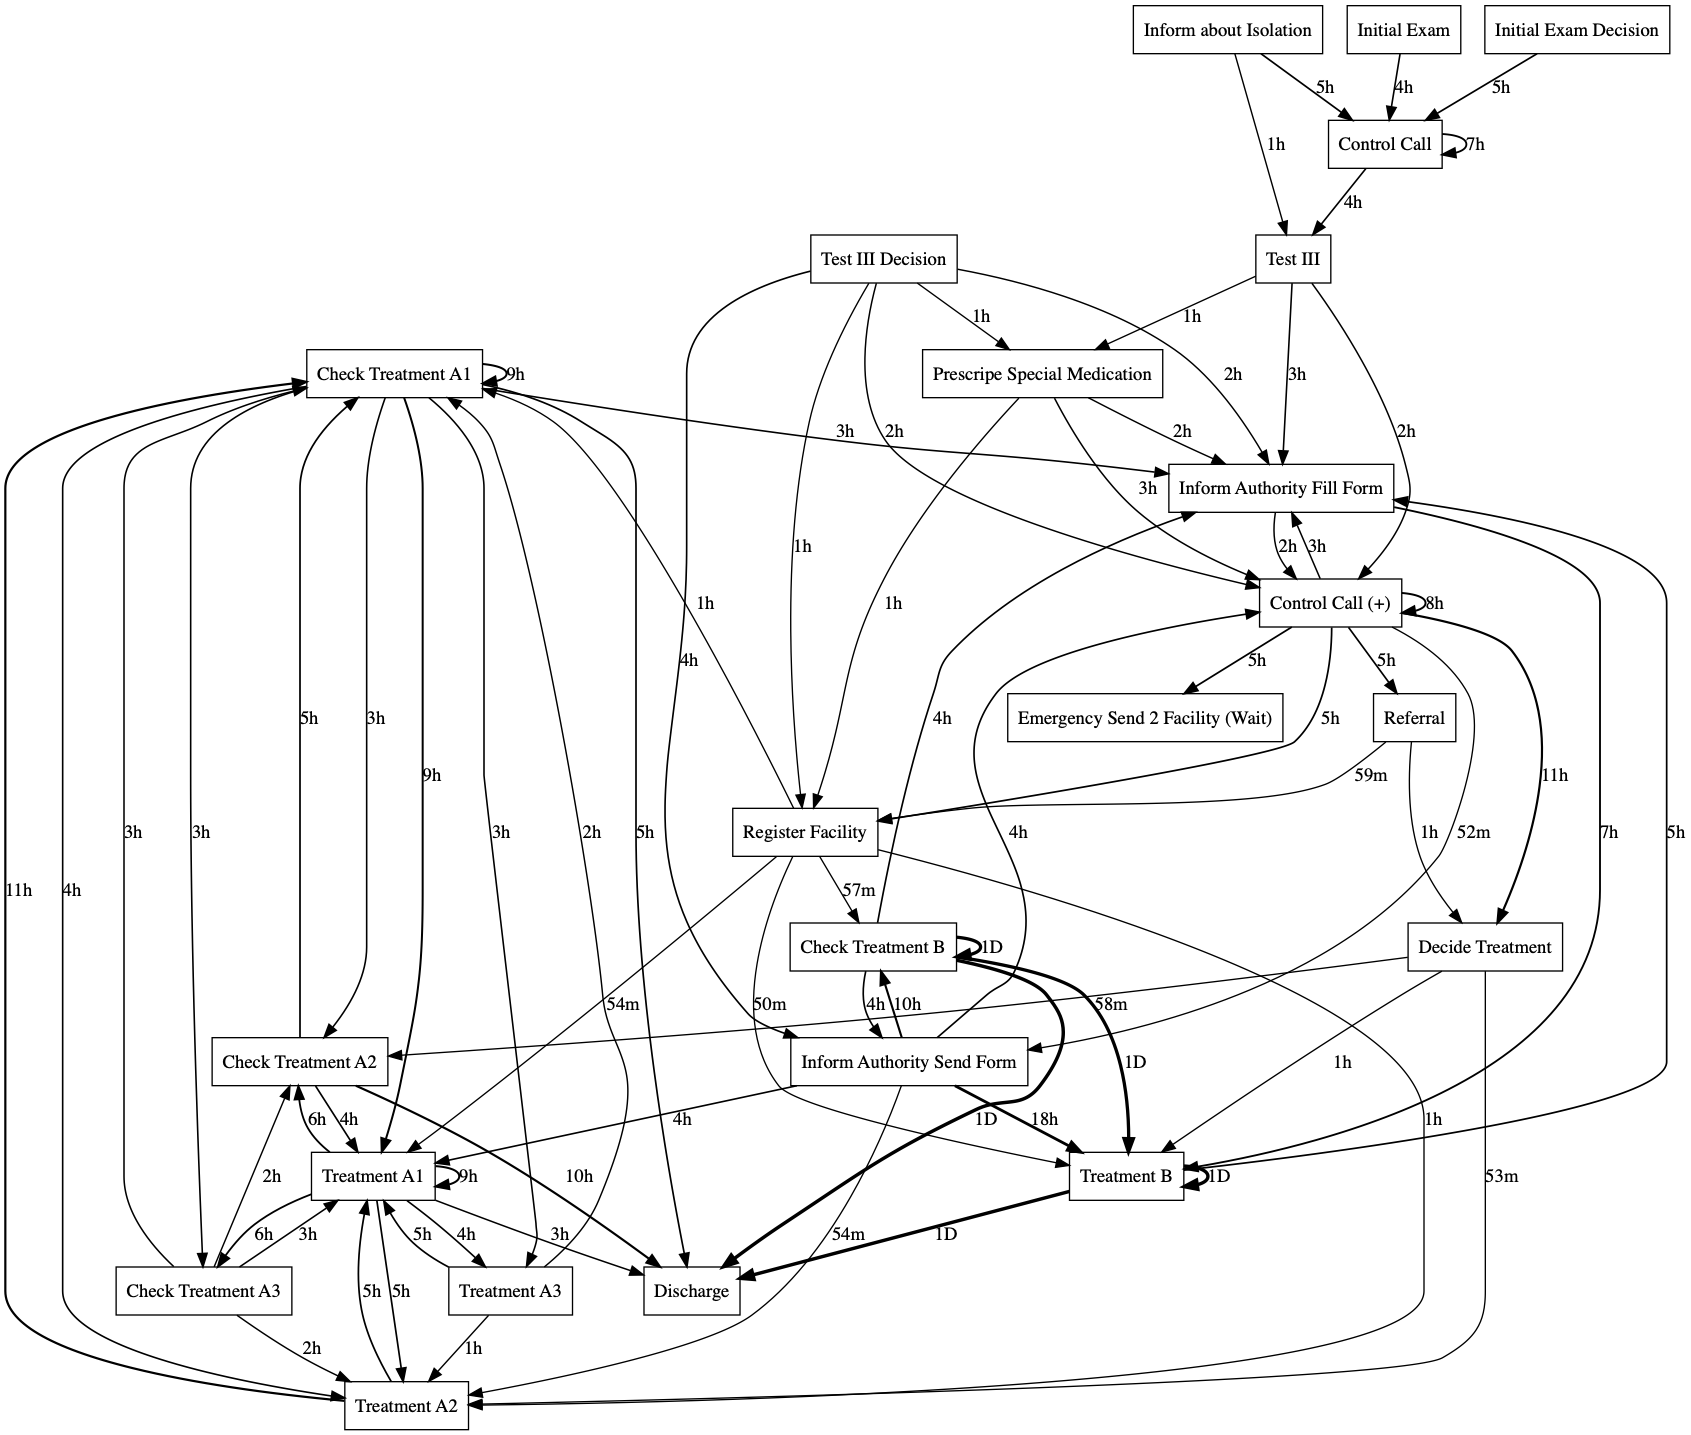

In [81]:
long_cases_log = log_converter.apply(long_cases, parameters=param_keys)

dfg = dfg_discovery.apply(long_cases_log, variant="performance", parameters=param_keys)
gviz = dfg_visualization.apply(dfg, log=long_cases_log, variant="performance")
dfg_visualization.view(gviz)

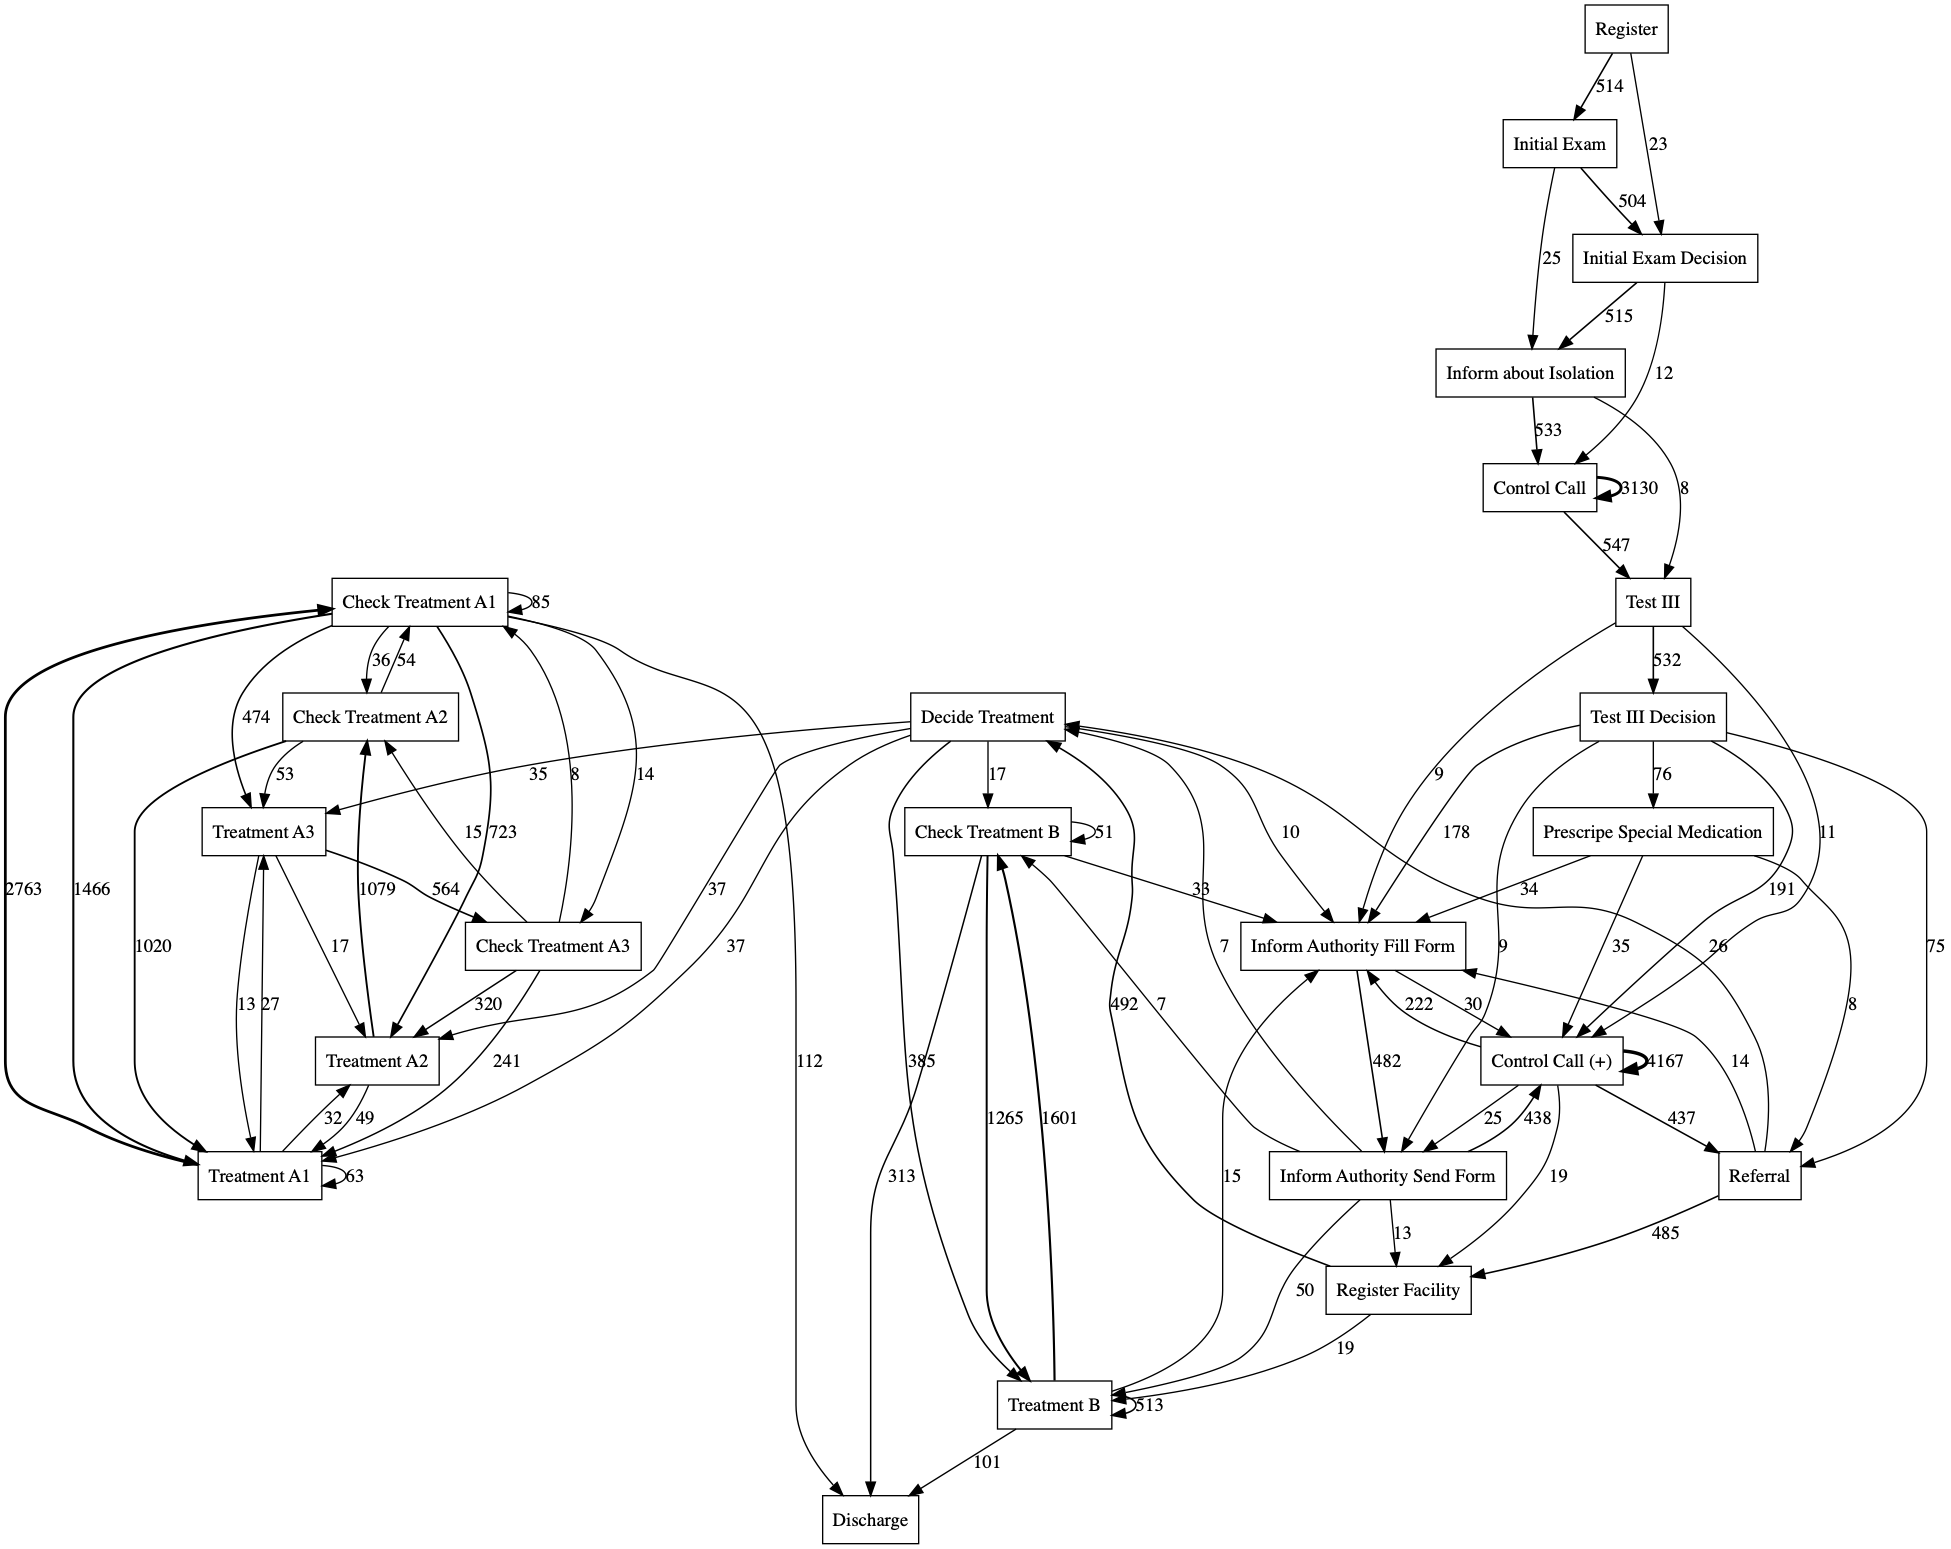

In [83]:
dfg = dfg_discovery.apply(long_cases_log, variant="frequency", parameters=param_keys)
gviz = dfg_visualization.apply(dfg, log=long_cases_log, variant="frequency")
dfg_visualization.view(gviz)

When we look at the frequency graph we can see that the control call activities are both very often repeated and have a high mean lead time of 7 or 8 hours. They are a big factor in the long running cases.

In [84]:
print(long_cases['Activity'].value_counts()[:2])
print(df_renaming['Activity'].value_counts()[:2])

Control Call (+)    4872
Control Call        3677
Name: Activity, dtype: int64
Control Call        5082
Control Call (+)    4872
Name: Activity, dtype: int64


A brief comparison of the number of control call activities shows that all control calls after a positive test are still included. This is normal because patients that receive a positive test results will naturally have longer case durations. What is really interesting is that around 72% of the control calls before the test are still included in the long cases. This means that some of the long running cases are caused by patients waiting a long time for a test (and receiving calls while they do).